In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
import seaborn as sns
sns.set()
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.ar_model import AutoReg
import warnings

In [3]:
main_data = pd.read_csv("global_data.csv") #import data

In [218]:
main_data.head()
warnings.filterwarnings('ignore')

# Preprocessing Data
    1) Extract the cases of India from dataset
    2) Convert "Date" from string to "DateTime" Object
    3) Deleting some data, to filter out only the required part
    4) Normalizing the data
    5) Setting the frequency of time-series analysis as "daily" 

In [5]:
main_data = main_data[65282:66095] #importing data of India only

In [6]:
#Set the Date to DateTime object instead of plain text and setting it as my data index
main_data["Date"] = pd.to_datetime(main_data["Date"],dayfirst=True)
main_data.set_index(main_data["Date"],inplace=True) 

In [7]:
del main_data["Date"],main_data["Country"],main_data["Recovered"]

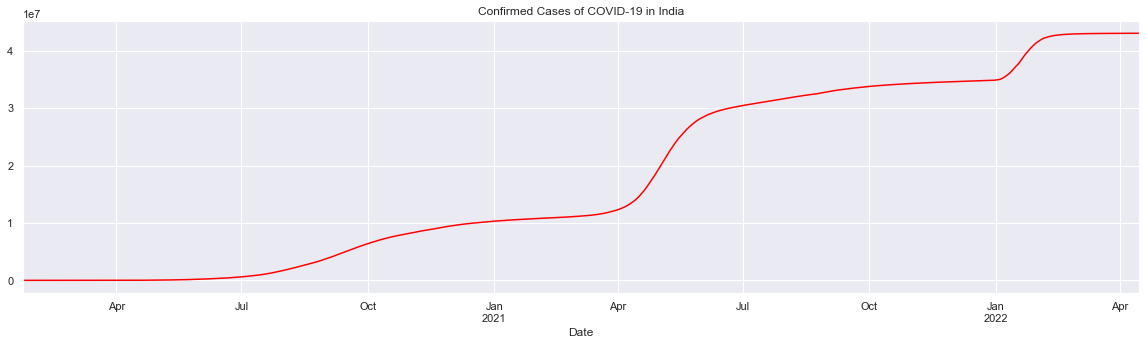

In [10]:
main_data["Confirmed"].plot(title="Confirmed Cases of COVID-19 in India",figsize=(20,5),color="Red")
plt.show()

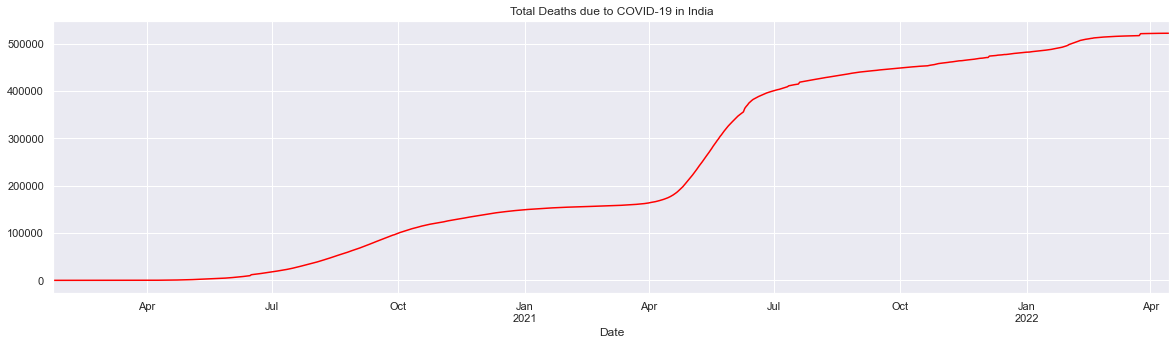

In [11]:
main_data["Deaths"].plot(title="Total Deaths due to COVID-19 in India",figsize=(20,5),color="Red")
plt.show()

In [21]:
main_data = main_data.asfreq('d') #Setting the frequency as "daily"

In [22]:
main_data.isna().sum() #To verify the presence of NaN values

Confirmed    0
Deaths       0
dtype: int64

In [36]:
#Normalizing the data
# x=> (x-min)/(max-min)
mini=[main_data["Confirmed"].min(),main_data["Deaths"].min()]
maxi=[main_data["Confirmed"].max(),main_data["Deaths"].max()]
main_data["N_Confirmed"] = (main_data["Confirmed"]-mini[0])/(maxi[0]-mini[0])
main_data["N_Deaths"]=(main_data["Deaths"]-mini[1])/(maxi[1]-mini[1])

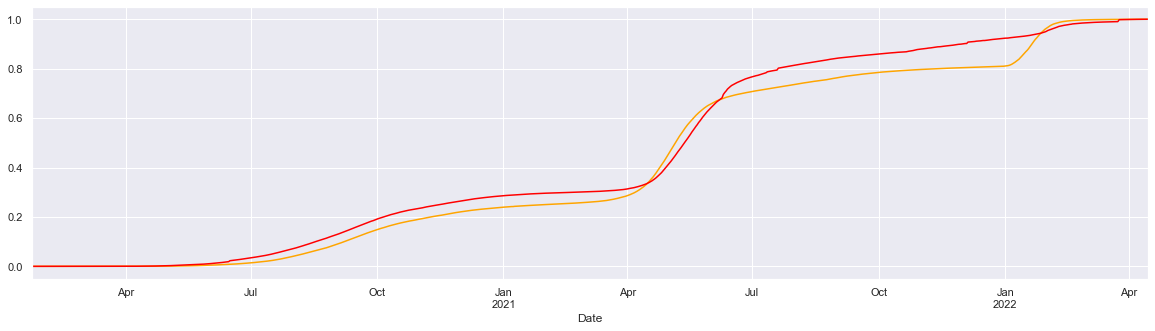

In [37]:
main_data["N_Confirmed"].plot(figsize=(20,5),color="Orange") #Plots of normalized data
main_data["N_Deaths"].plot(figsize=(20,5),color="Red")
plt.show() 

In [38]:
#To split the data into training and testing set => 80% of data will be part of training set and 20% will be of testing set
sz = int(len(main_data)*0.8) #sz is my splitting point
df_train = main_data[:sz]
df_test = main_data[sz:]

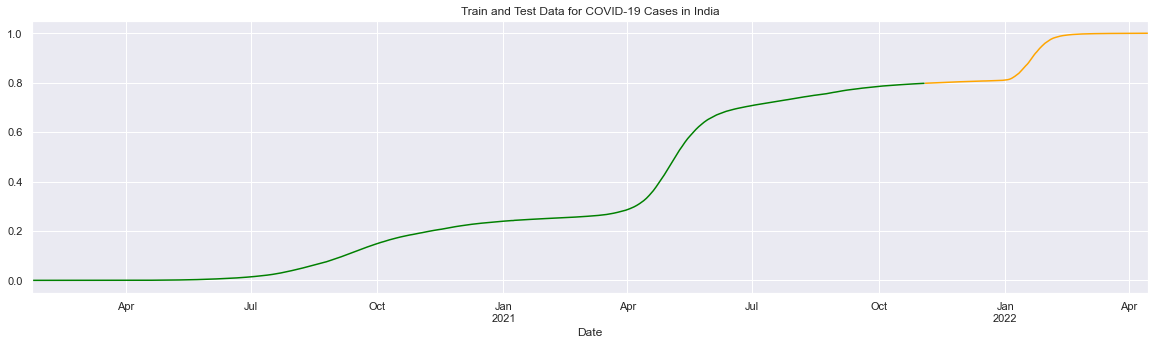

In [39]:
df_train["N_Confirmed"].plot(title="Train and Test Data for COVID-19 Cases in India",figsize=(20,5),color="Green")
df_test["N_Confirmed"].plot(title="Train and Test Data for COVID-19 Cases in India",figsize=(20,5),color="Orange")
plt.show()

# Trying a simple Auto-Regressive Model

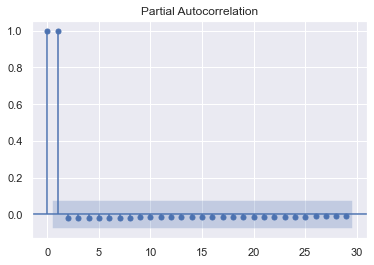

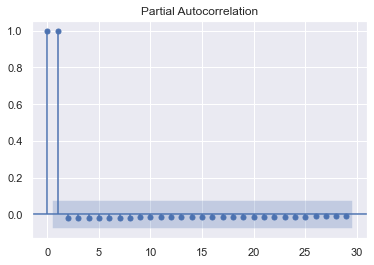

In [40]:
plot_pacf(df_train["N_Confirmed"]) #The graph shows that PACF Coefficients become insignificant after 1. So I will use AR(1) model

In [56]:
#AR(1) model
AR_model = AutoReg(df_test["N_Confirmed"],lags=1)
AR_model_fit=AR_model.fit()

In [57]:
pred_start_date = df_test.index[0] #Getting the starting and ending dates from the testing data
pred_end_date = df_test.index[-1]

In [58]:
df_test["AR_Confirmed"] = AR_model_fit.predict(start=pred_start_date,end=pred_end_date)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\Users\Game\AppData\Local\Temp/ipykernel_5216/4159578614.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["AR_Confirmed"] = AR_model_fit.predict(start=pred_start_date,end=pred_end_date)


<AxesSubplot:title={'center':'Actual Data Vs Predicted Data of simple AR(1) Model'}, xlabel='Date'>

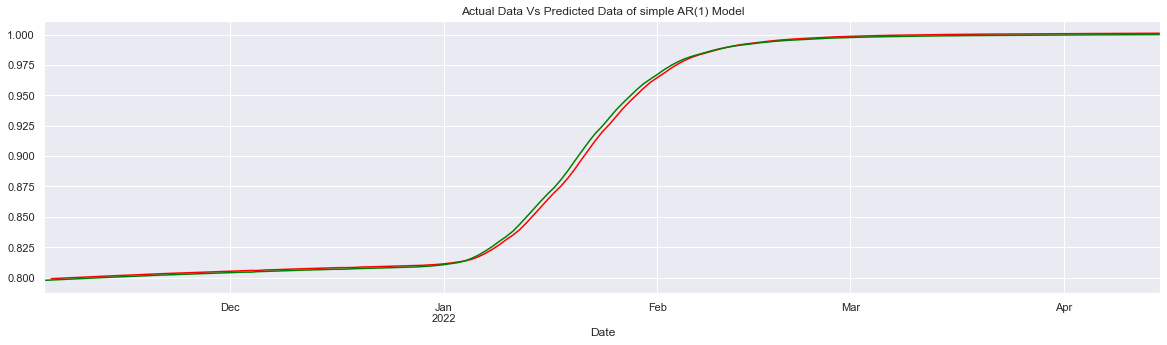

In [61]:
df_test["AR_Confirmed"].plot(title="Actual Data Vs Predicted Data of simple AR(1) Model",figsize=(20,5),color="Red")
df_test["N_Confirmed"].plot(figsize=(20,5),color="Green") #Plotting the Actual Vs Predicted Data

In [219]:
AR_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:            N_Confirmed   No. Observations:                  163
Model:                     AutoReg(1)   Log Likelihood                 767.717
Method:               Conditional MLE   S.D. of innovations              0.002
Date:                Tue, 03 May 2022   AIC                            -12.279
Time:                        06:43:11   BIC                            -12.222
Sample:                    11-05-2021   HQIC                           -12.256
                         - 04-15-2022                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.0023      0.002      1.371      0.170      -0.001       0.006
N_Confirmed.L1     0.9988      0.002    537.859      0.000       0.995       1.002
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0012           +0.0000j            1.0012            0.0000
-----------------------------------------------------------------------------
"""

C:\Users\Game\AppData\Local\Temp/ipykernel_5216/816641246.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["AR_Error"] = df_test["N_Confirmed"]-df_test["AR_Confirmed"]


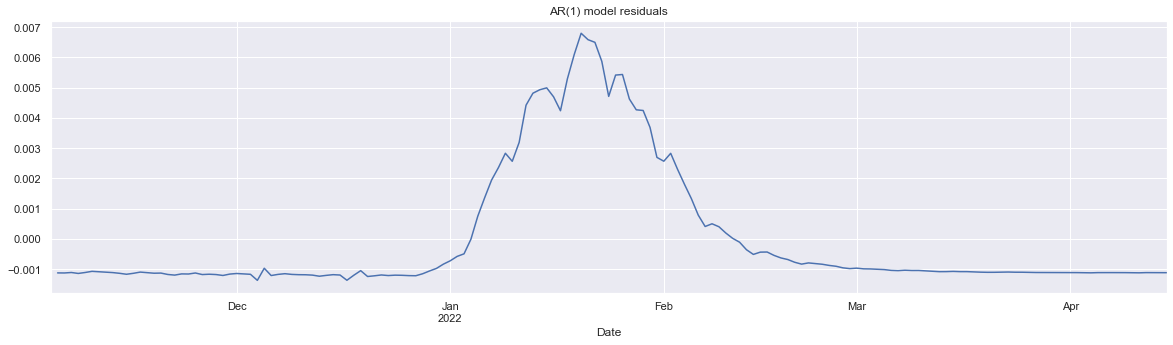

In [207]:
df_test["AR_Error"] = df_test["N_Confirmed"]-df_test["AR_Confirmed"]
df_test["AR_Error"].plot(title="AR(1) model residuals",figsize=(20,5))
plt.show()

In [230]:
df_test["ARIMA_RF_Error"].describe()

count    163.000000
mean       0.000019
std        0.000273
min       -0.001165
25%       -0.000015
50%        0.000002
75%        0.000030
max        0.001171
Name: ARIMA_RF_Error, dtype: float64

In [227]:
result = adfuller(df_test["AR_Error"].dropna()) #P value > 0.05 strong evidence for non-stationarity
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1]) 

ADF Statistic: -2.452579
p-value: 0.127443


In [231]:
result = adfuller(df_test["ARIMA_RF_Error"].dropna()) #P value > 0.05 strong evidence for non-stationarity
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1]) 

ADF Statistic: -2.798555
p-value: 0.058480


In [154]:
AR_error = mean_squared_error(df_test["AR_Confirmed"][1:],df_test["N_Confirmed"][1:])
print("The mean squared error using AR(1) model is :",AR_error,".","Its square root is:",np.sqrt(AR_error))

The mean squared error using AR(1) model is : 4.48012849017104e-06 . Its square root is: 0.0021166314015839036


# ARIMA (Auto Regressive Integrated Moving Average Model)

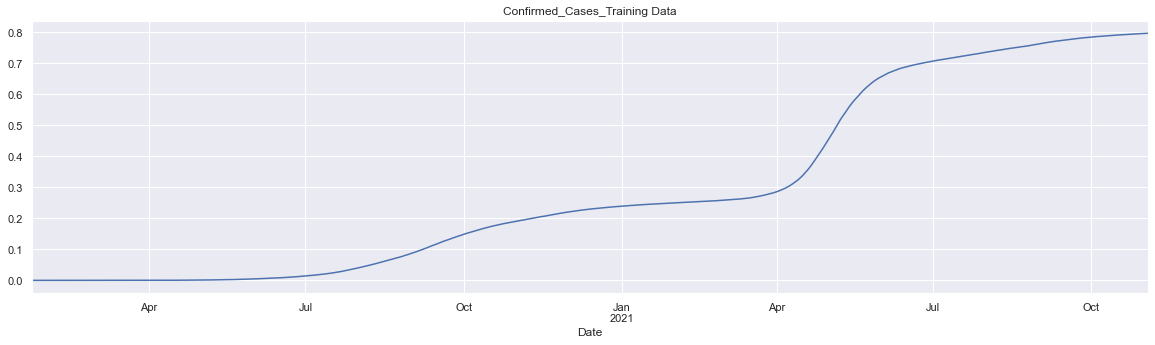

In [64]:
#Plotting the training dataset
df_train["N_Confirmed"].plot(title="Confirmed_Cases_Training Data",figsize=(20,5))
plt.show()

Doesn't Look Stationary
    Mean is increasing (not constant)
    A bit of seasonality is there
Let's do adfuller test

In [65]:
result = adfuller(df_train["N_Confirmed"]) #P value > 0.05 strong evidence for non-stationarity
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1]) 

ADF Statistic: 0.373683
p-value: 0.980484


C:\Users\Game\AppData\Local\Temp/ipykernel_5216/3394638427.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["N_C_1st_Diff"] = df_train["N_Confirmed"].diff()


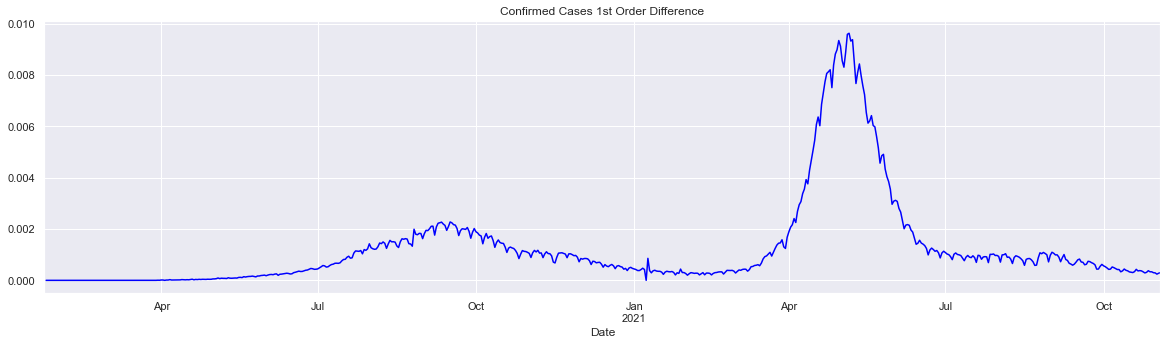

In [66]:
df_train["N_C_1st_Diff"] = df_train["N_Confirmed"].diff()
df_train["N_C_1st_Diff"].plot(title="Confirmed Cases 1st Order Difference",figsize=(20,5),color="Blue")
plt.show()

In [68]:
result = adfuller(df_train["N_C_1st_Diff"].dropna()) #P value > 0.05 strong evidence for non-stationarity
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1]) #D = 0

ADF Statistic: -2.641601
p-value: 0.084700


C:\Users\Game\AppData\Local\Temp/ipykernel_5216/2665614371.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["N_C_2nd_Diff"] = df_train["N_C_1st_Diff"].diff()


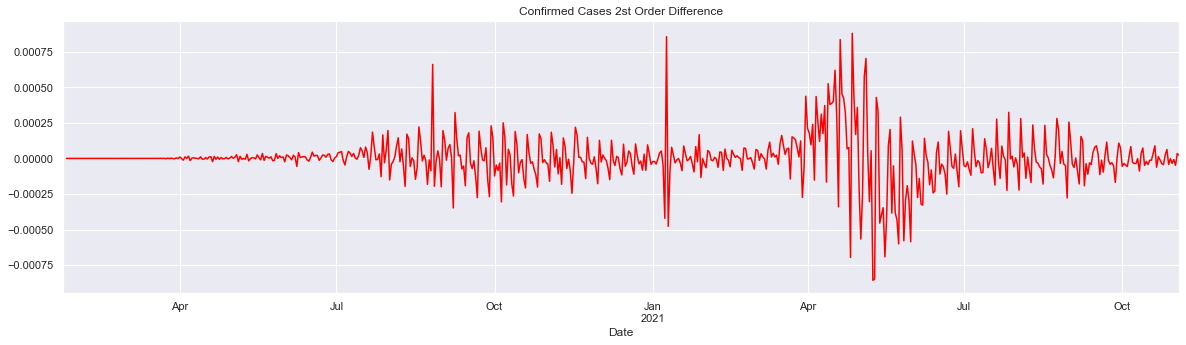

In [70]:
df_train["N_C_2nd_Diff"] = df_train["N_C_1st_Diff"].diff()
df_train["N_C_2nd_Diff"].plot(title="Confirmed Cases 2st Order Difference",figsize=(20,5),color="Red")
plt.show()

In [72]:
result = adfuller(df_train["N_C_2nd_Diff"].dropna()) #P-value < 0.05 , no strong evidence against non-stationarity
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1]) #D = 0

ADF Statistic: -5.194490
p-value: 0.000009


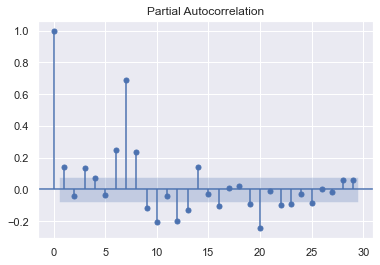

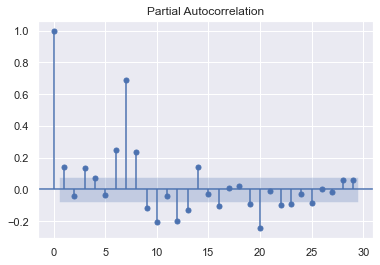

In [74]:
plot_pacf(df_train["N_C_2nd_Diff"].dropna()) #AR -> 3 or 4 or 7 or 8

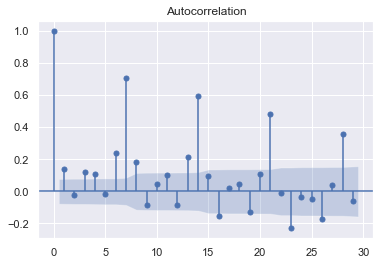

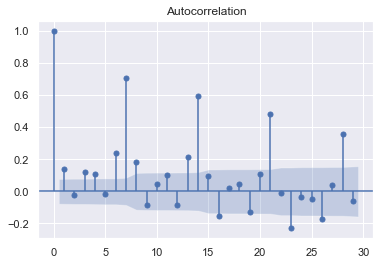

In [75]:
plot_acf(df_train["N_C_2nd_Diff"].dropna()) #MA -> 1 or 4

In [166]:
#ARIMA(4,2,4)
ARIMA_model = ARIMA(df_train["N_Confirmed"],order=(4,2,1))
ARIMA_model_fit = ARIMA_model.fit()

In [167]:
df_test["ARIMA_Confirmed"] = ARIMA_model_fit.predict(start=pred_start_date,end=pred_end_date,typ="levels")

C:\Users\Game\AppData\Local\Temp/ipykernel_5216/1792848201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["ARIMA_Confirmed"] = ARIMA_model_fit.predict(start=pred_start_date,end=pred_end_date,typ="levels")


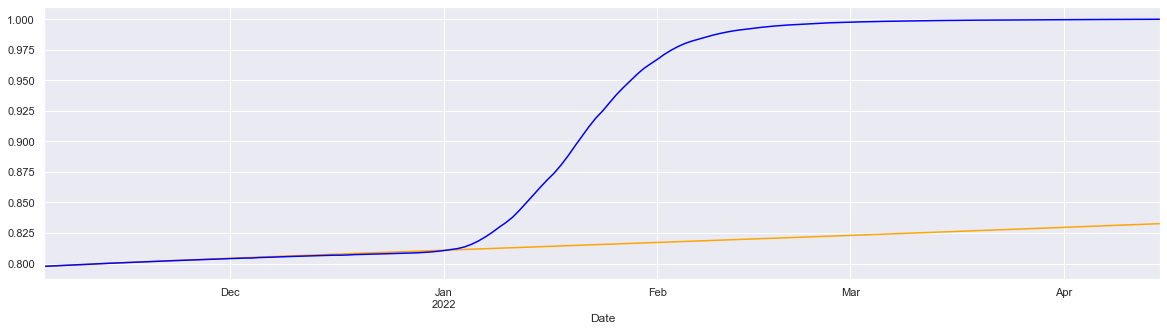

In [169]:
df_test["ARIMA_Confirmed"].plot(figsize=(20,5),color="Orange")
df_test["N_Confirmed"].plot(figsize=(20,5),color="Blue")
plt.show()

# Improving further with rolling forecast ARIMA Model

In [233]:
history=[x for x in df_train["Confirmed"]]
for t in range(len(df_test)):
    model = ARIMA(history,order=(4,2,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    df_test["ARIMA_RF"][t]=output[0][0]
    history.append(df_test["Confirmed"][t])

In [234]:
df_test["ARIMA_RF"] = (df_test["ARIMA_RF"]-mini[0])/(maxi[0]-mini[0]) #Renormalize the data

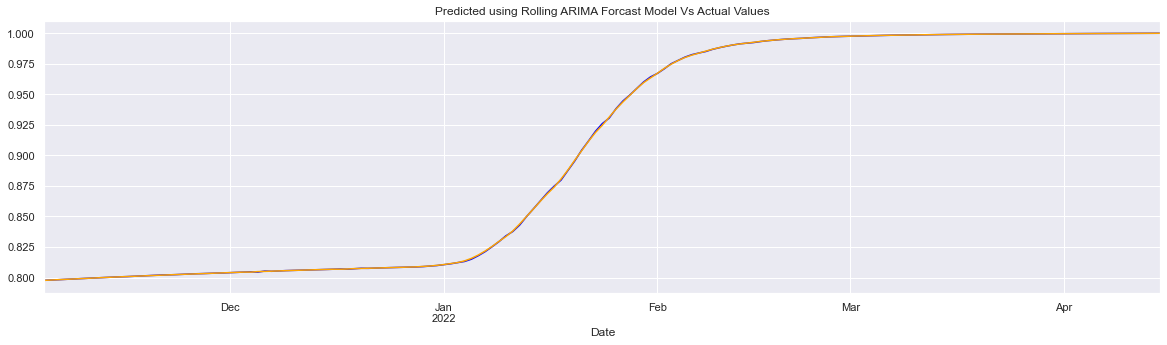

In [235]:
df_test["ARIMA_RF"].plot(figsize=(20,5),color="Blue") #Plotting the Actual Vs Predicted Data
df_test["N_Confirmed"].plot(figsize=(20,5),color="Orange")
plt.title("Predicted using Rolling ARIMA Forcast Model Vs Actual Values")
plt.show()

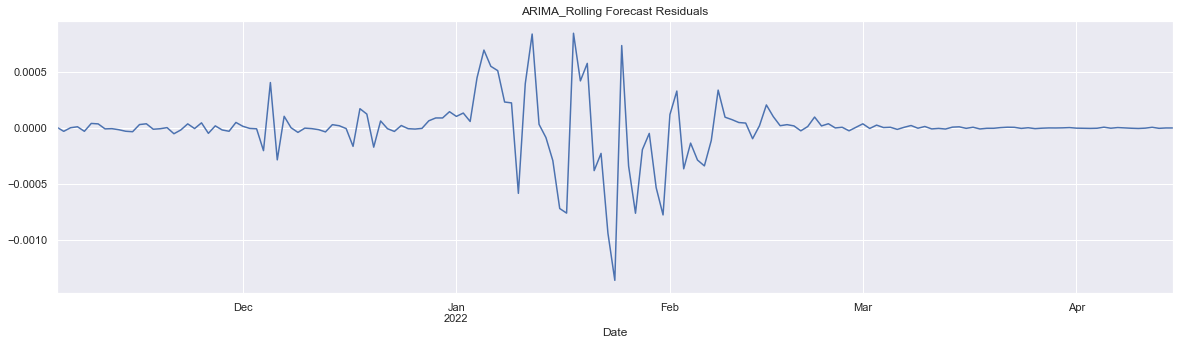

In [236]:
df_test["ARIMA_RF_Error"] = df_test["N_Confirmed"] - df_test["ARIMA_RF"] 
df_test["ARIMA_RF_Error"].plot(title="ARIMA_Rolling Forecast Residuals",figsize=(20,5))
plt.show()

In [238]:
ARIMA_RF_error = mean_squared_error(df_test["ARIMA_RF"][1:],df_test["N_Confirmed"][1:])
print("The mean squared error using AR(1) model is :",AR_error,".","Its square root is:",np.sqrt(ARIMA_error))

The mean squared error using AR(1) model is : 4.48012849017104e-06 . Its square root is: 0.00027240564516510404


In [239]:
df_test["ARIMA_RF_Error"].describe()

count    1.630000e+02
mean    -2.778741e-06
std      2.637702e-04
min     -1.360602e-03
25%     -1.330169e-05
50%      8.508782e-07
75%      3.714605e-05
max      8.466517e-04
Name: ARIMA_RF_Error, dtype: float64

In [245]:
df_test["AR_Error"].describe()

count    1.620000e+02
mean    -1.439178e-17
std      2.123195e-03
min     -1.366022e-03
25%     -1.125090e-03
50%     -1.078452e-03
75%     -3.731726e-04
max      6.800344e-03
Name: AR_Error, dtype: float64

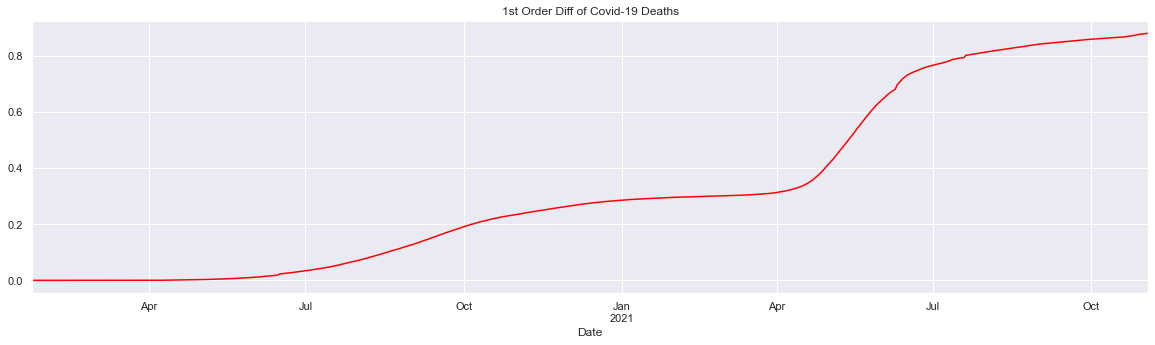

In [266]:
df_train["N_Deaths"].plot(title="1st Order Diff of Covid-19 Deaths",figsize=(20,5),color="Red")
plt.show()

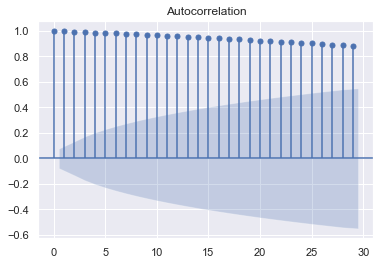

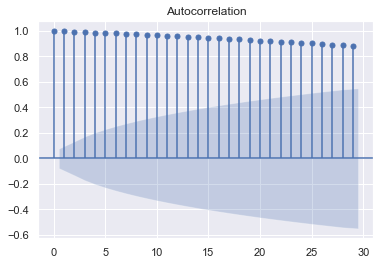

In [267]:
plot_acf(df_train["N_Deaths"].dropna()) #MA -> 1

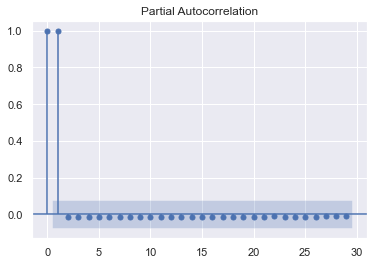

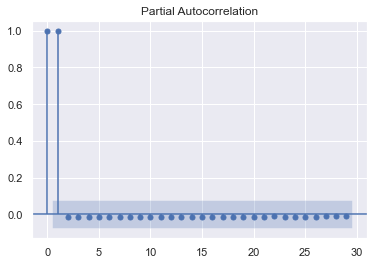

In [268]:
plot_pacf(df_train["N_Deaths"].dropna()) #AR -> 2

In [255]:
df_test["ARIMA_RF_Deaths"]=df_test["Confirmed"]

In [270]:
AR_model2 = AutoReg(df_test["N_Deaths"],lags=1)
AR_model_fit2=AR_model2.fit()

In [271]:
df_test["ARIMA_RF_Deaths"]=AR_model_fit2.predict(start=pred_start_date,end=pred_end_date)

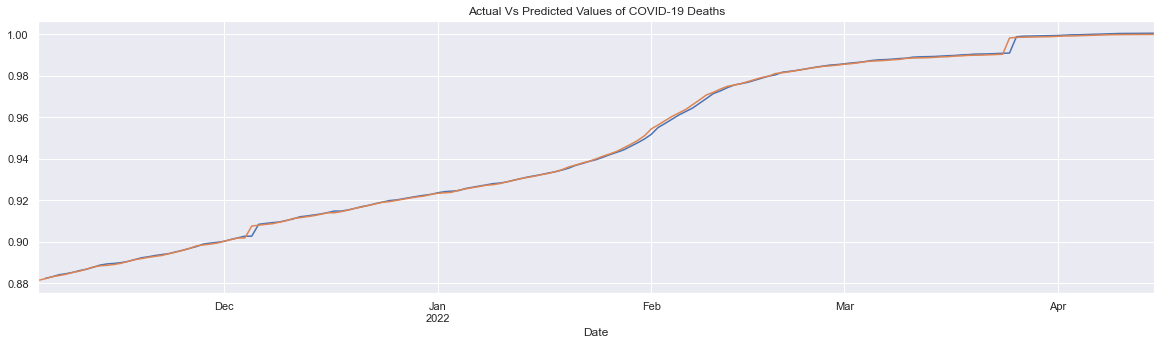

In [273]:
df_test["ARIMA_RF_Deaths"].plot(title="Actual Vs Predicted Values of COVID-19 Deaths",figsize=(20,5))
df_test["N_Deaths"].plot(title="Actual Vs Predicted Values of COVID-19 Deaths",figsize=(20,5))
plt.show()

In [274]:
df_test["Error"]=df_test["N_Deaths"]-df_test["ARIMA_RF_Deaths"]

In [276]:
df_test["Error"][2:].describe()

count    161.000000
mean       0.000001
std        0.000884
min       -0.000868
25%       -0.000433
50%       -0.000214
75%        0.000042
max        0.007261
Name: Error, dtype: float64